In [139]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [140]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../data/benchmark-wsl2"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if "." not in file:
            continue

        print(file)

        file_type = file.split("_")[1]

        print(f"Processing {file}")

        tuning_algorithm = directory.split("/")[-1]
        ruleset = directory.split("/")[-2]
        scenario = directory.split("/")[-3]

        with open(os.path.join(directory, file)) as f:
            content = f.read()
            df = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not ruleset in data[scenario]:
            data[scenario][ruleset] = {}

        if not tuning_algorithm in data[scenario][ruleset]:
            data[scenario][ruleset][tuning_algorithm] = {}

        data[scenario][ruleset][tuning_algorithm][file_type] = df

AutoPas_tuningData_Rank0_2024-06-08_19-27-06.csv
Processing AutoPas_tuningData_Rank0_2024-06-08_19-27-06.csv
AutoPas_liveInfoLogger_Rank0_2024-06-08_19-27-06.csv
Processing AutoPas_liveInfoLogger_Rank0_2024-06-08_19-27-06.csv
AutoPas_tuningResults_Rank0_2024-06-08_19-27-06.csv
Processing AutoPas_tuningResults_Rank0_2024-06-08_19-27-06.csv
AutoPas_iterationPerformance_Rank0_2024-06-08_19-27-06.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-08_19-27-06.csv
AutoPas_tuningResults_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_tuningResults_Rank0_2024-06-07_21-22-46.csv
AutoPas_tuningData_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_tuningData_Rank0_2024-06-07_21-22-46.csv
AutoPas_iterationPerformance_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_21-22-46.csv
AutoPas_predictions_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_predictions_Rank0_2024-06-07_21-22-46.csv
AutoPas_liveInfoLogger_Rank0_2024-06-07_21-22-46.csv
Processing Au

In [141]:
#columns
df.head()

,Date,Iteration,inTuningPhase,Container,CellSizeFactor,Traversal,Load Estimator,Data Layout,Newton 3,iteratePairwise[ns],remainderTraversal[ns],rebuildNeighborLists[ns],iteratePairwiseTotal[ns],tuning[ns],energyPsys[J],energyPkg[J],energyRam[J]
0,2024-06-09 00:56:51,0,True,LinkedCells,1.0,lc_c01,none,AoS,disabled,175624688,19883072,431,195512859,53840674,NaN,NaN,NaN
1,2024-06-09 00:56:51,1,True,LinkedCells,1.0,lc_c01,none,AoS,disabled,192920291,3841452,0,196766502,23212381,NaN,NaN,NaN
2,2024-06-09 00:56:52,2,True,LinkedCells,1.0,lc_c01,none,AoS,disabled,220341939,10098433,0,230604369,28490093,NaN,NaN,NaN
3,2024-06-09 00:56:52,3,True,LinkedCells,1.0,lc_c01,none,SoA,disabled,103131701,17723402,741,120861004,24410525,NaN,NaN,NaN
4,2024-06-09 00:56:52,4,True,LinkedCells,1.0,lc_c01,none,SoA,disabled,76905196,11988124,0,88897817,17947619,NaN,NaN,NaN


# Make Line Plot of Smoothed Value over Iterations


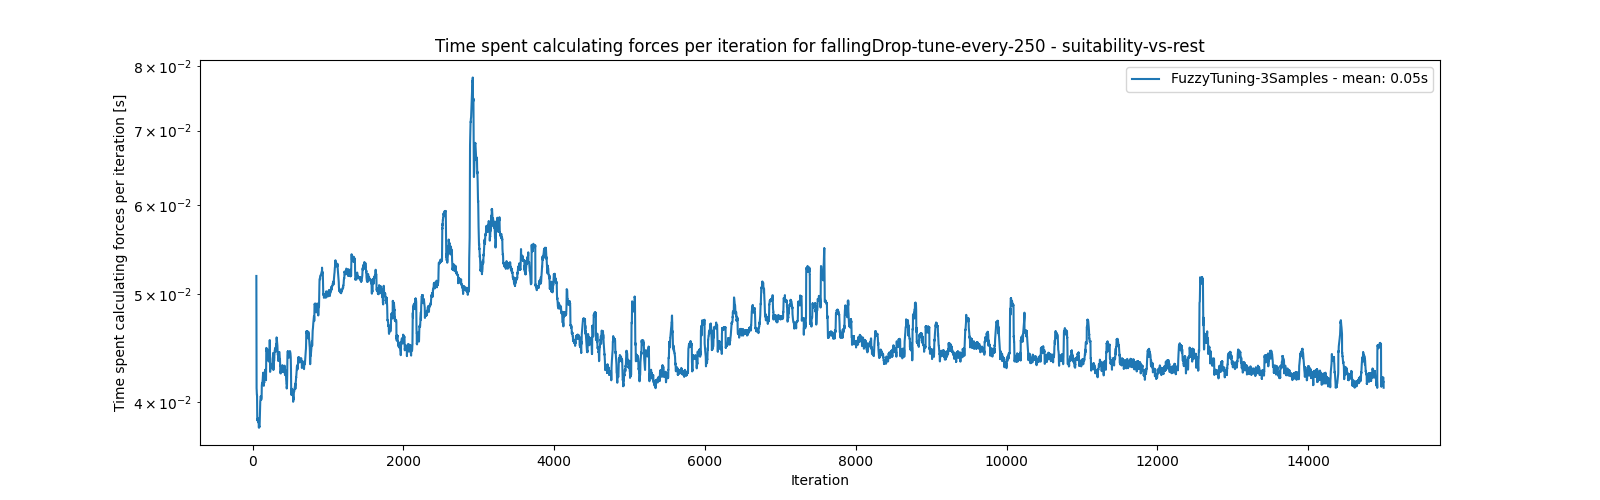

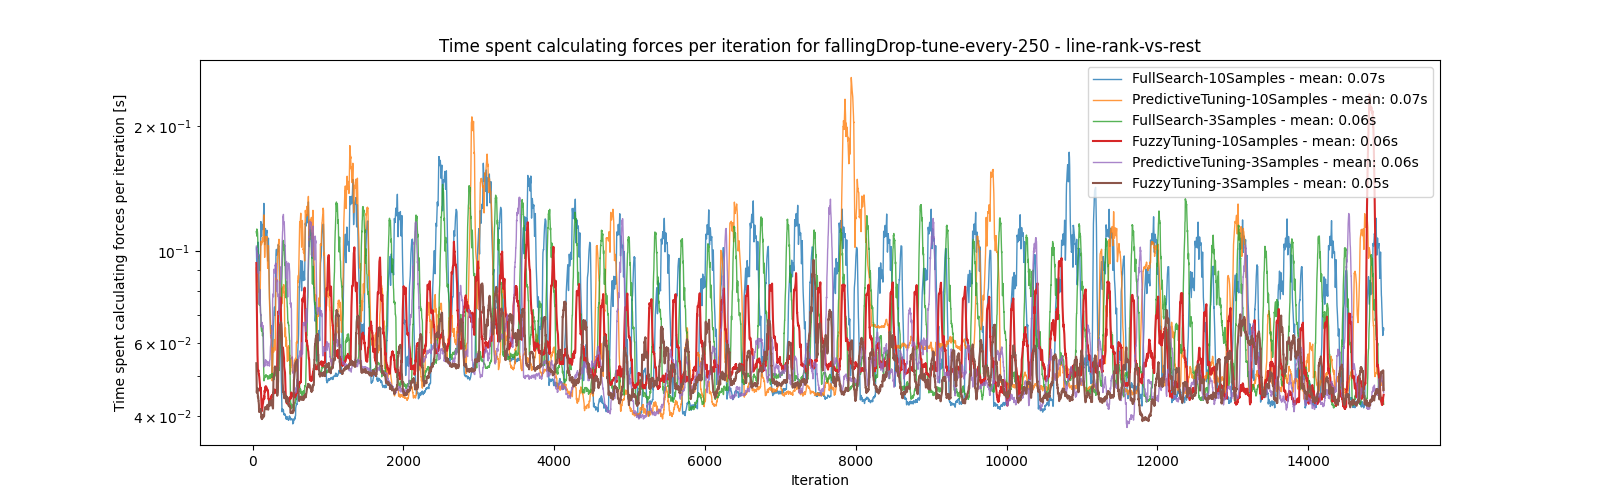

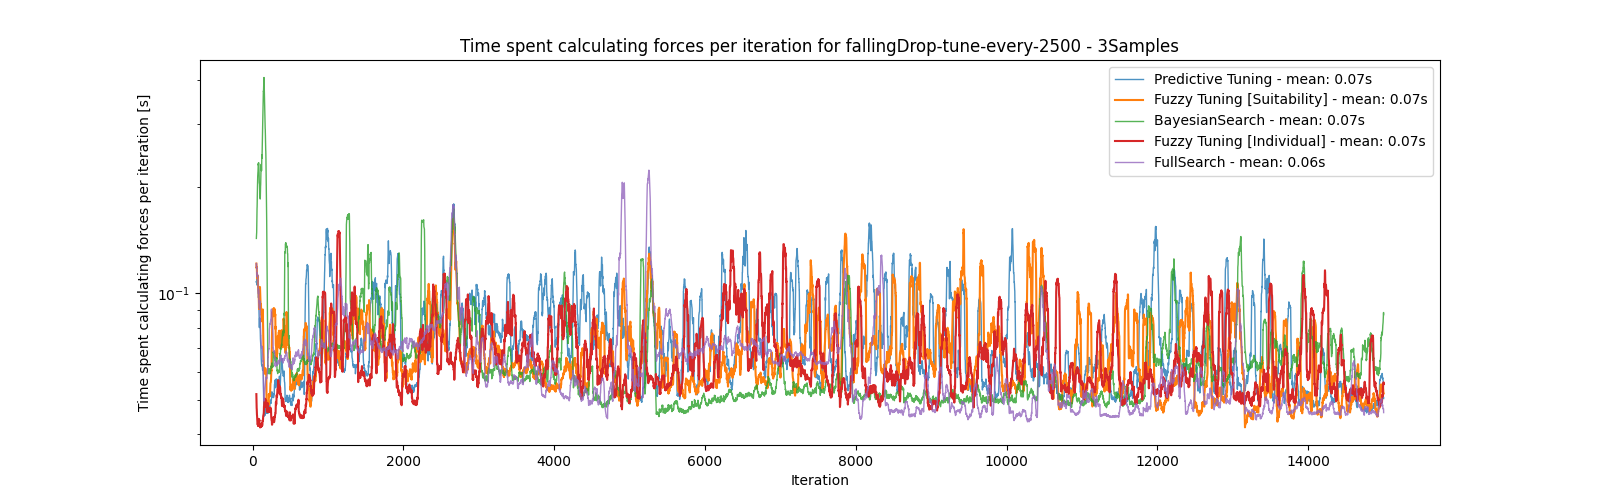

In [142]:


for scenario, s_data in data.items():

    for ruleset, r_data in s_data.items():
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["iteratePairwise[ns]"].mean(), reverse=True):

            iteration_data = logs["iterationPerformance"]

            time_s = iteration_data["iteratePairwise[ns]"] / 1e9

            first_k = 1000000

            x = iteration_data["Iteration"][:first_k]
            y = time_s[:first_k].rolling(window=50).mean()

            linewidth = 1.5 if "Fuzzy" in tuning_algorithm else 1
            opacity = 1 if "Fuzzy" in tuning_algorithm else 0.8

            mean = y.mean()

            ax.plot(x, y, label=f"{
                    tuning_algorithm} - mean: {mean:.2f}s", linewidth=linewidth, alpha=opacity)

        ax.legend()
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Time spent calculating forces per iteration [s]")
        ax.set_title(f"Time spent calculating forces per iteration for {
            scenario} - {ruleset}")
        # ax.set_xlim(0, df["Iteration"].max())
        #log
        ax.set_yscale("log")
        plt.show()

# Make bar plots about total time

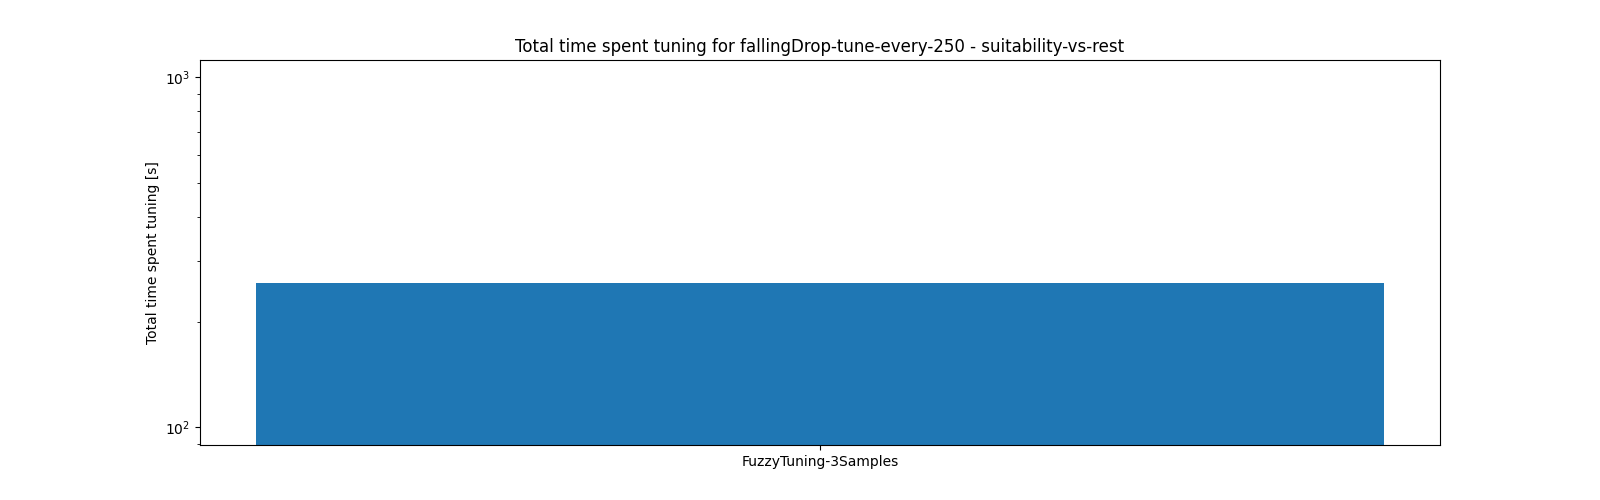

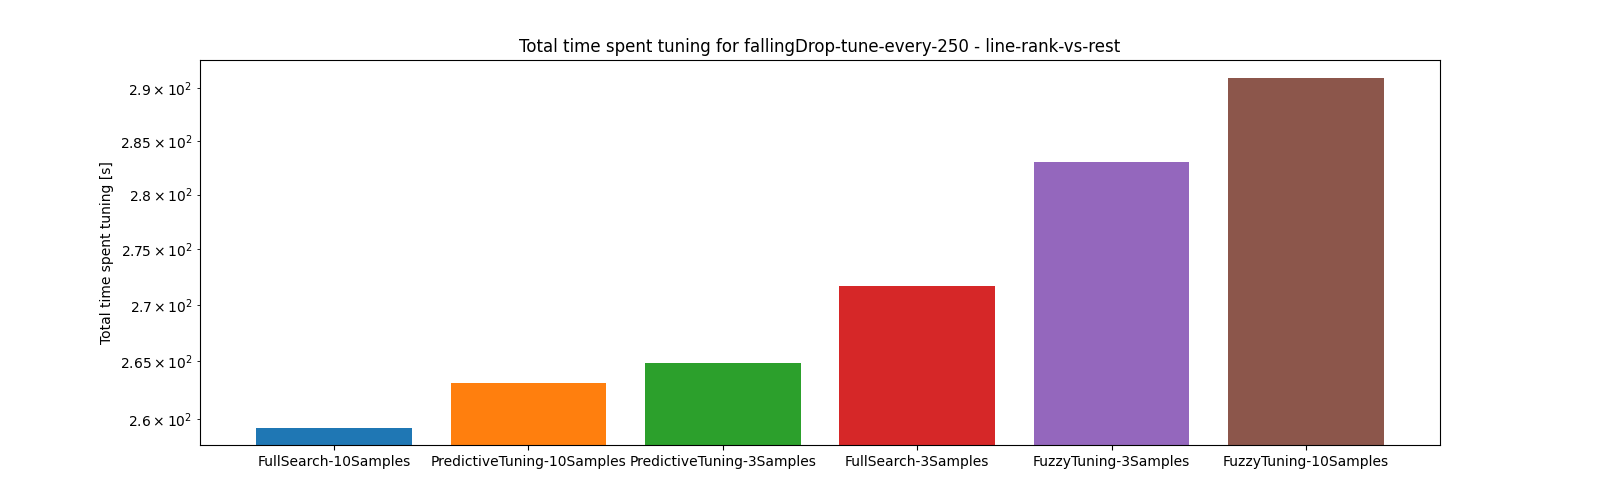

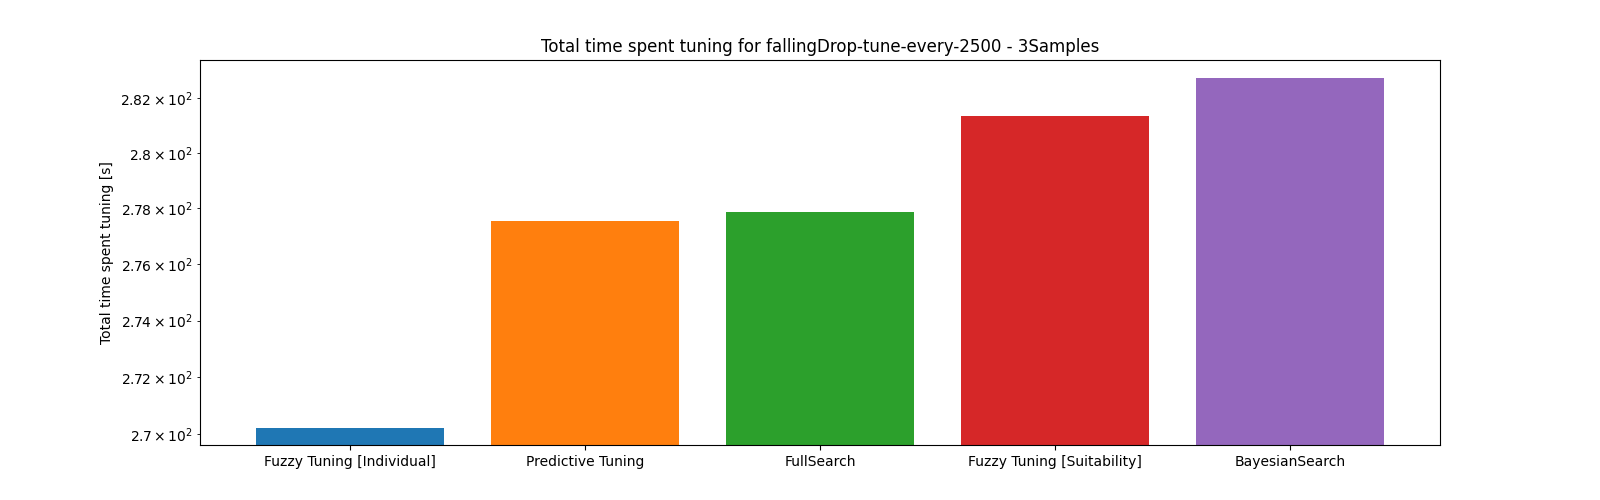

In [145]:
for scenario, s_data in data.items():

    for ruleset, r_data in s_data.items():
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in sorted(r_data.items(), key=lambda x: x[1]["iterationPerformance"]["tuning[ns]"].sum(), reverse=False):

            iteration_data = logs["iterationPerformance"]

            total_time_s = iteration_data["tuning[ns]"].sum() / 1e9

            ax.bar(tuning_algorithm, total_time_s, label=f"{tuning_algorithm}")

        ax.set_ylabel("Total time spent tuning [s]")
        ax.set_title(f"Total time spent tuning for {scenario} - {ruleset}")
        ax.set_yscale("log")
        plt.show()